In [151]:
import os
import random 

os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4,6,7"

In [152]:
import numpy
print(numpy.__version__)

1.25.2


In [153]:

from peft import LoraConfig
from trl import SFTTrainer

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset, Dataset

from tqdm import tqdm
from torch.utils.data import Dataset

from peft import get_peft_model, LoraConfig
# from bitsandbytes import nn

import nltk
from nltk.tree import Tree

import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader


# from torchtext.legacy import data
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


from datasets import load_dataset
import torch
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import time
import math
from torch.optim import AdamW

from tqdm import tqdm

import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

#### Convert PCFG Data form to actual Data

In [ ]:
def extract_raw_sentence(pcfg_parsed_text):
    """
    Extracts raw sentence from PCFG parsed output.
    
    Args:
    pcfg_parsed_text (str): A string representation of the PCFG parsed tree.
    
    Returns:
    str: Extracted raw sentence.
    """
    try:
        tree = Tree.fromstring(pcfg_parsed_text)
        raw_sentence = " ".join(tree.leaves())
        return raw_sentence
    except ValueError:
        return ""

# Load the data
def load_and_preprocess_data(train_path, valid_path, test_path):

    # process train dataset
    train_df = pd.read_csv(train_path, sep='\t')
    train_df['premise'] = train_df['Sent1_parse'].apply(extract_raw_sentence)
    train_df['hypothesis'] = train_df['Sent2_parse'].apply(extract_raw_sentence)

    # process validation dataset
    valid_df = pd.read_csv(valid_path, sep='\t')
    valid_df['premise'] = valid_df['Sent1_parse'].apply(extract_raw_sentence)
    valid_df['hypothesis'] = valid_df['Sent2_parse'].apply(extract_raw_sentence)

    # process test dataset
    test_df = pd.read_csv(test_path, sep='\t')
    test_df['premise'] = test_df['Sent1_parse'].apply(extract_raw_sentence)
    test_df['hypothesis'] = test_df['Sent2_parse'].apply(extract_raw_sentence)

    return train_df, valid_df, test_df

##### please create dataset folder, and put train.tsv, dev.tsv, test.tsv inside it

In [120]:
# Load datasets
train_df, valid_df, test_df = load_and_preprocess_data(
    './dataset/train.tsv', './dataset/dev.tsv', './dataset/test.tsv'
)

In [121]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(550152, 5)
(10000, 5)
(10000, 5)


In [122]:
train_df['premise'][0]

'A person on a horse jumps over a broken down airplane .'

In [123]:
train_df['hypothesis'][0]

'A person is training his horse for a competition .'

### Visualize premise and hypothesis lengths plot

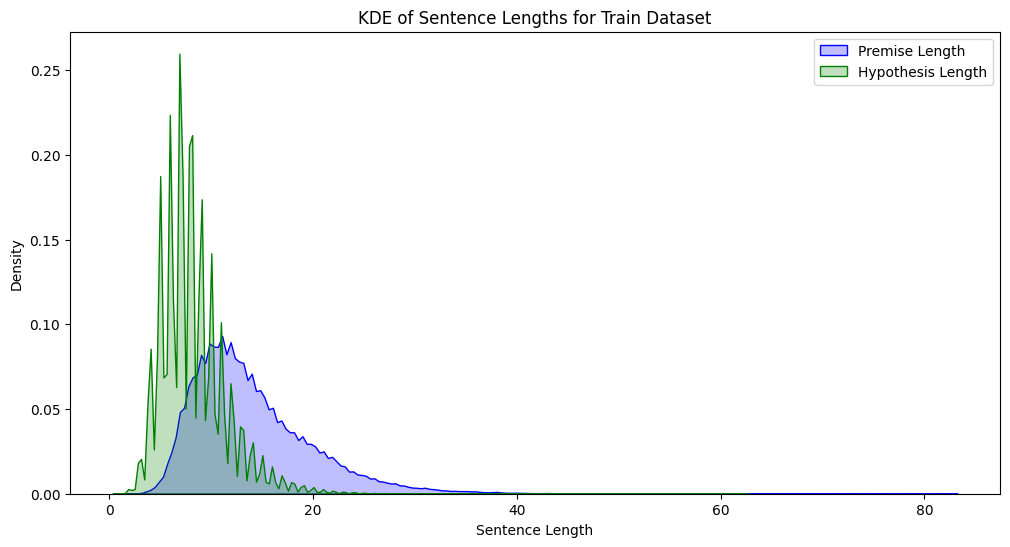

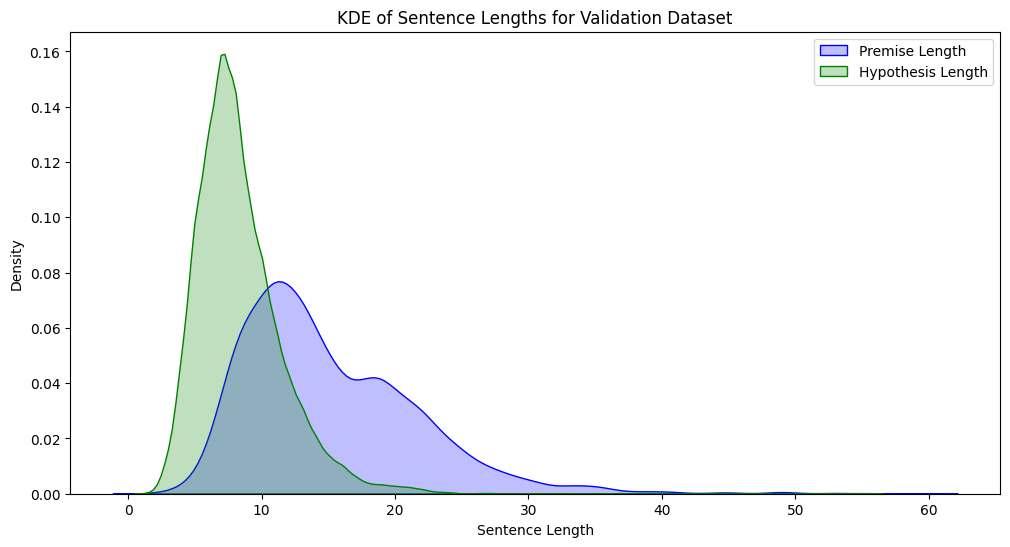

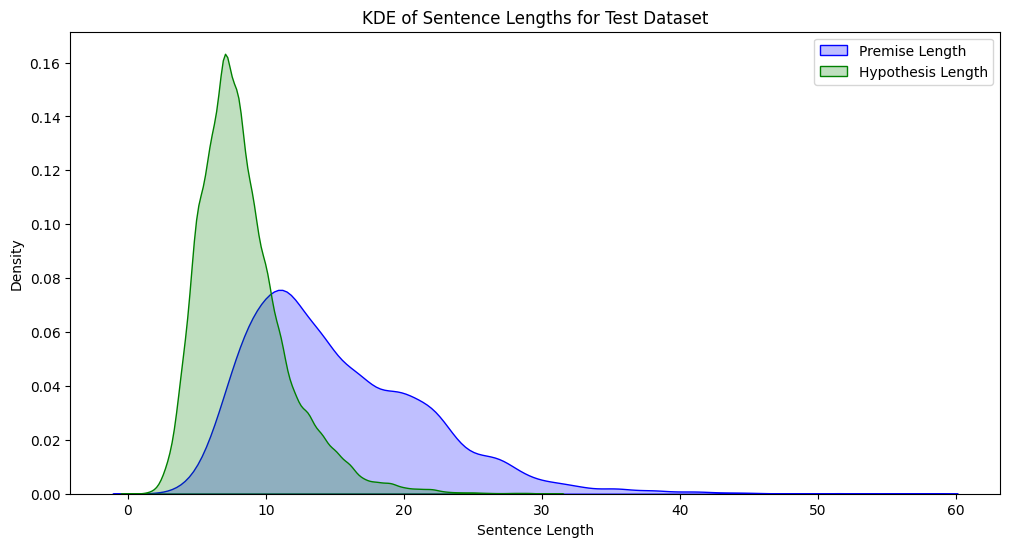

In [124]:


# Calculate the length of premise and hypothesis sentences
def calculate_sentence_lengths(df):
    df['premise_length'] = df['premise'].apply(lambda x: len(x.split()))
    df['hypothesis_length'] = df['hypothesis'].apply(lambda x: len(x.split()))
    return df


# Calculate sentence lengths for each dataset
train_df = calculate_sentence_lengths(train_df)
valid_df = calculate_sentence_lengths(valid_df)
test_df = calculate_sentence_lengths(test_df)


def plot_kde(df, dataset_name):
    plt.figure(figsize=(12, 6))

    # Plot KDE for premise lengths
    sns.kdeplot(df['premise_length'], color='blue', label='Premise Length', fill=True)

    # Plot KDE for hypothesis lengths
    sns.kdeplot(df['hypothesis_length'], color='green', label='Hypothesis Length', fill=True)

    # Add labels and title
    plt.title(f'KDE of Sentence Lengths for {dataset_name} Dataset')
    plt.xlabel('Sentence Length')
    plt.ylabel('Density')
    plt.legend()

    # Show the plot
    plt.show()

# Plot KDE for train, validation, and test datasets
plot_kde(train_df, 'Train')
plot_kde(valid_df, 'Validation')
plot_kde(test_df, 'Test')


In [125]:
# Analyzing the data
train_df.groupby('Label').count()

,Sent1_parse,Sent2_parse,premise,hypothesis,premise_length,hypothesis_length
Label,,,,,,
-,785,785,785,785,785,785
contradiction,183187,183187,183187,183187,183187,183187
entailment,183416,183416,183416,183416,183416,183416
neutral,182764,182764,182764,182764,182764,182764


In [126]:
# removing the entries from all train, dev and test datasets with label '-'
train_df = train_df[train_df['Label'] != '-']
valid_df = valid_df[valid_df['Label'] != '-']
test_df = test_df[test_df['Label'] != '-']

In [127]:
# dropping the rows from the data with NaN values
train_df = train_df.dropna(subset = ['hypothesis'])

train_df.groupby('Label').count()

,Sent1_parse,Sent2_parse,premise,hypothesis,premise_length,hypothesis_length
Label,,,,,,
contradiction,183187,183187,183187,183187,183187,183187
entailment,183416,183416,183416,183416,183416,183416
neutral,182764,182764,182764,182764,182764,182764


#### Extract Sequence, Attention Mask, Token Type, Label

In [162]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define constants
max_sentence_length = 128
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id
cls_token_idx = tokenizer.cls_token_id
sep_token_idx = tokenizer.sep_token_id



def preprocess_nli_data(df):

    df['premise'] =  df['premise'].apply(lambda x: x.split())
    df['hypothesis'] =  df['hypothesis'].apply(lambda x: x.split())

    df['premise'] =  df['premise'].apply(lambda x: x if len(x)<=64 else x[:64])
    df['hypothesis'] =  df['hypothesis'].apply(lambda x: x if len(x)<=64 else x[:64])

    df['premise'] =  df['premise'].apply(lambda x: " ".join(x))
    df['hypothesis'] =  df['hypothesis'].apply(lambda x: " ".join(x))
    

    df['sent1'] = df['premise'].apply(lambda x: '[CLS] ' + x + ' [SEP] ')
    df['sent2'] = df['hypothesis'].apply(lambda x: x + ' [SEP]')

    df['tokenize_sent1'] = df['sent1'].apply(lambda x: tokenizer.tokenize(x))
    df['tokenize_sent2'] = df['sent2'].apply(lambda x: tokenizer.tokenize(x))


    df['sentence'] = df.apply(lambda row: row['tokenize_sent1'] + row['tokenize_sent2'], axis=1)

    df['attention_mask'] = df['sentence'].apply(lambda x: ['1'] * len(x))  
    df['token_type_ids'] = df.apply( lambda row: ['0'] * (len(row['tokenize_sent1'])) +  ['1'] * (len(row['tokenize_sent2'])), axis=1)

    df['sequence'] = df['sentence'].apply(lambda x: " ".join(x))
    df['attention_mask'] = df['attention_mask'].apply(lambda x: " ".join(x))
    df['token_type'] = df['token_type_ids'].apply(lambda x: " ".join(x))
    
    return df


loading file vocab.txt from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.

In [129]:

# Preprocess NLI data
train_df = preprocess_nli_data(train_df)
valid_df = preprocess_nli_data(valid_df)
test_df = preprocess_nli_data(test_df)

train_df = train_df[['Label', 'sequence', 'attention_mask', 'token_type']]
valid_df = valid_df[['Label', 'sequence', 'attention_mask', 'token_type']]
test_df = test_df[['Label', 'sequence', 'attention_mask', 'token_type']]
                  
train_df = train_df.loc[train_df['Label'].isin(['entailment','contradiction','neutral'])]
valid_df = valid_df.loc[valid_df['Label'].isin(['entailment','contradiction','neutral'])]
test_df = test_df.loc[test_df['Label'].isin(['entailment','contradiction','neutral'])]

# Save processed data
train_df.to_csv('./dataset/processed_train.csv', index=False)
valid_df.to_csv('./dataset/processed_valid.csv', index=False)
test_df.to_csv('./dataset/processed_test.csv', index=False)


In [130]:
# train_df = pd.read_csv("./dataset/processed_train.csv")
# test_df = pd.read_csv("./dataset/processed_test.csv")
# valid_df = pd.read_csv("./dataset/processed_valid.csv")

In [131]:
train_df.head(5)

,Label,sequence,attention_mask,token_type
0,neutral,[CLS] a person on a horse jumps over a broken ...,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
1,contradiction,[CLS] a person on a horse jumps over a broken ...,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 ...
2,entailment,[CLS] a person on a horse jumps over a broken ...,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
3,neutral,[CLS] children smiling and waving at camera [S...,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
4,entailment,[CLS] children smiling and waving at camera [S...,1 1 1 1 1 1 1 1 1 1 1 1 1,0 0 0 0 0 0 0 0 1 1 1 1 1


In [132]:
# sen = train_df['sequence'][0]
# tokens = sen.split(' ')
# print(tokens)
# ids = tokenizer.convert_tokens_to_ids(tokens)
# print(ids)

In [133]:
####   [CLS]->101   [SEP]->102   [PAD]->0   [UNK]->100

#### Create DataLoader Specific to BERT Model

In [134]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer


class NliDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        sequence = self.dataframe.iloc[idx]['sequence']
        tokens = sequence.split(' ')
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        attention_mask = self.dataframe.iloc[idx]['attention_mask']
        token_type_ids = self.dataframe.iloc[idx]['token_type']

        attention_mask = list(map(int, attention_mask.split()))
        token_type_ids = list(map(int, token_type_ids.split()))


        # Convert the label into an integer
        label = self.dataframe.iloc[idx]['Label']
        label_map = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
        label = label_map[label]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long),
            'length': len(input_ids)
        }



In [135]:
def collate_fn(batch):
    batch = sorted(batch, key=lambda x: x['length'])
    
    # Find the max length in the batch
    max_len = max([x['length'] for x in batch])
    
    # Initialize padded tensors
    input_ids = torch.zeros(len(batch), max_len, dtype=torch.long)
    attention_mask = torch.zeros(len(batch), max_len, dtype=torch.long)
    token_type_ids = torch.ones(len(batch), max_len, dtype=torch.long)
    labels = torch.zeros(len(batch), dtype=torch.long)

    # Fill the tensors with the batch data
    for i, item in enumerate(batch):
        input_ids[i, :item['length']] = item['input_ids']
        attention_mask[i, :item['length']] = item['attention_mask']
        token_type_ids[i, :item['length']] = item['token_type_ids']
        labels[i] = item['label']
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'label': labels
    }

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Load data (you need to load your dataframe here)
train_df = pd.read_csv('./dataset/processed_train.csv')
valid_df = pd.read_csv('./dataset/processed_valid.csv')
test_df = pd.read_csv('./dataset/processed_test.csv')

# Sort the DataFrames by sequence length
train_df['length'] = train_df['sequence'].apply(lambda x: len(x.split(' ')))
valid_df['length'] = valid_df['sequence'].apply(lambda x: len(x.split(' ')))
test_df['length'] = test_df['sequence'].apply(lambda x: len(x.split(' ')))

# Sort by the length column
train_df = train_df.sort_values(by='length', ascending=True).reset_index(drop=True)
valid_df = valid_df.sort_values(by='length', ascending=True).reset_index(drop=True)
test_df = test_df.sort_values(by='length', ascending=True).reset_index(drop=True)

# Create Datasets
train_dataset = NliDataset(train_df, tokenizer)
valid_dataset = NliDataset(valid_df, tokenizer)
test_dataset = NliDataset(test_df, tokenizer)



loading file vocab.txt from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.

In [137]:
# Create DataLoader
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

#### Define Custom Model using BERT for Classification Task

In [157]:

# Define BERT-based NLI Model
class BERTNLIModel(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim):
        super().__init__()
        self.bert = bert_model
        embedding_dim = bert_model.config.to_dict()['hidden_size']
        self.out = nn.Linear(embedding_dim, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids):
        embedded = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )[1]  # Use the pooled output
        output = self.out(embedded)
        return output


In [158]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [159]:

# Initialize BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')
HIDDEN_DIM = 512
OUTPUT_DIM = 3  # 'entailment', 'contradiction', 'neutral'
model = BERTNLIModel(bert_model, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-6)
criterion = nn.CrossEntropyLoss().to(device)

# Training loop
N_EPOCHS = 3
warmup_percent = 0.2
total_steps = math.ceil(N_EPOCHS * len(train_dataloader) / BATCH_SIZE)
warmup_steps = int(total_steps * warmup_percent)


loading configuration file config.json from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /data/home/arunkumar12/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetenso

In [141]:
# function to count the parameters of the model
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p. requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,484,547 trainable parameters


In [142]:
def get_scheduler(optimizer, warmup_steps):
    scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)
    return scheduler
criterion = nn.CrossEntropyLoss().to(device)


In [143]:

def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True)

    correct = (max_preds.squeeze(1)==y).float()

    return correct.sum() / len(y)

#### Model Training

In [144]:
max_grad_norm = 1
def train(model, iterator, optimizer, criterion, scheduler):
    epoch_loss = 0
    epoch_acc = 0
    idx = 0
    model.train()
    pbar = tqdm(iterator, desc="Training")
    for batch in pbar:
        optimizer.zero_grad() # clear gradients first
        torch.cuda.empty_cache() 
        sequence = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        token_type = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)
        predictions = model(sequence, attn_mask, token_type)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        pbar.set_description(f"Loss: {epoch_loss / (idx + 1):.4f} | Acc: {epoch_acc / (idx + 1):.4f}")

        idx += 1
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#### Model Evaluation

In [145]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    idx = 0
    with torch.no_grad():
        pbar = tqdm(iterator, desc="Validation")
        for batch in pbar:
            sequence = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            token_type = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)
            predictions = model(sequence, attn_mask, token_type)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

            pbar.set_description(f"Loss: {epoch_loss / (idx + 1):.4f} | Acc: {epoch_acc / (idx + 1):.4f}")

            idx += 1


    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Model Testing

In [146]:


def test(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_macro_f1 = 0
    model.eval()
    idx = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(iterator, desc="Test")
        for batch in pbar:
            sequence = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            token_type = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)

            # Get predictions from the model
            predictions = model(sequence, attn_mask, token_type)

            # Compute loss
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            # Calculate F1 score
            preds = torch.argmax(predictions, dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            
            # Calculate micro F1 and macro F1
            f1 = f1_score(labels_np, preds, average='micro')
            macro_f1 = f1_score(labels_np, preds, average='macro')

            # Aggregate metrics
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1
            epoch_macro_f1 += macro_f1

            # Store predictions and labels for later (optional)
            all_preds.extend(preds)
            all_labels.extend(labels_np)

            # Update progress bar description
            pbar.set_description(f"Loss: {epoch_loss / (idx + 1):.4f} | Acc: {epoch_acc / (idx + 1):.4f} | "
                                 f"Micro F1: {epoch_f1 / (idx + 1):.4f} | Macro F1: {epoch_macro_f1 / (idx + 1):.4f}")

            idx += 1

    # Compute the final metrics
    avg_loss = epoch_loss / len(iterator)
    avg_acc = epoch_acc / len(iterator)
    avg_f1 = epoch_f1 / len(iterator)
    avg_macro_f1 = epoch_macro_f1 / len(iterator)

    return avg_loss, avg_acc, avg_f1, avg_macro_f1


In [147]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Start Training and Validation

In [ ]:
import math
N_EPOCHS = 3
warmup_percent = 0.2
total_steps = math.ceil(N_EPOCHS*len(train_dataloader)*1./BATCH_SIZE)
warmup_steps = int(total_steps*warmup_percent)
scheduler = get_scheduler(optimizer, warmup_steps)
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, scheduler)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Loss: 0.4082 | Acc: 0.8428: 100%|██████████| 34336/34336 [1:00:00<00:00,  9.54it/s]
Loss: 0.2974 | Acc: 0.8899: 100%|██████████| 616/616 [00:14<00:00, 42.91it/s]


Epoch: 01 | Epoch Time: 60m 15s
Train Loss: 0.408 | Train Acc: 84.28%
Val. Loss: 0.297 | Val. Acc: 88.99%


Loss: 0.2833 | Acc: 0.8973: 100%|██████████| 34336/34336 [1:05:54<00:00,  8.68it/s]
Loss: 0.2743 | Acc: 0.9028: 100%|██████████| 616/616 [00:15<00:00, 40.72it/s]


Epoch: 02 | Epoch Time: 66m 9s
Train Loss: 0.283 | Train Acc: 89.73%
Val. Loss: 0.274 | Val. Acc: 90.28%


Loss: 0.2198 | Acc: 0.9220: 100%|██████████| 34336/34336 [1:10:00<00:00,  8.17it/s]
Loss: 0.3076 | Acc: 0.8994: 100%|██████████| 616/616 [00:13<00:00, 46.28it/s]

Epoch: 03 | Epoch Time: 70m 14s
Train Loss: 0.220 | Train Acc: 92.20%
Val. Loss: 0.308 | Val. Acc: 89.94%


### Testing

In [161]:
model.load_state_dict(torch.load('best-model.pt'))
test_loss, test_acc, test_f1, test_macro_f1 = test(model, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc:.2f} | Test F1: {test_f1:.3f} | Test Macro F1: {test_macro_f1:.3f}')

Loss: 0.2834 | Acc: 0.9020 | Micro F1: 0.9020 | Macro F1: 0.8909: 100%|██████████| 614/614 [00:13<00:00, 44.67it/s]

Test Loss: 0.283 |  Test Acc: 0.90 | Test F1: 0.902 | Test Macro F1: 0.891


### Prediction

In [195]:

def predict(model, premise, hypothesis, tokenizer, device):


    premise = premise.split()
    premise = premise if len(premise)<=64 else premise[:64]
    premise = " ".join(premise)
    premise = '[CLS] ' + premise + ' [SEP] '
    premise_tokens = tokenizer.tokenize(premise)
    # print("Premise tokens are:",premise_tokens)

    hypothesis = hypothesis.split()
    hypothesis = hypothesis if len(hypothesis)<=64 else hypothesis[:64]
    hypothesis = " ".join(hypothesis)
    hypothesis = hypothesis + ' [SEP]'
    hypothesis_tokens = tokenizer.tokenize(hypothesis)
    # print("Hypothesis tokens are:",hypothesis_tokens)

    tokens = premise_tokens + hypothesis_tokens
    # print("Combine sequence tokens are:",tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # print("Converted tokens into ids are:",input_ids)
    attention_mask = [1]*(len(tokens))
    # print("Corresponding attention mask is:", attention_mask)
    token_type_ids = [0]*len(premise_tokens) + [1]*len(hypothesis_tokens)
    # print("Corresponding token type is:", token_type_ids)


    input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
    attention_mask = torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0).to(device)

    
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Forward pass to get the logits
        outputs = model(input_ids, attention_mask, token_type_ids)

    predicted_class = torch.argmax(outputs, dim=-1).item()

    return predicted_class



In [196]:

model.load_state_dict(torch.load('best-model.pt'))
# Assuming the model is on GPU, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BERTNLIModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [199]:
dataset_path = "./dataset/test.tsv"
data = pd.read_csv(dataset_path, sep='\t')

for i in [100,200,300,400,500]:



    sent1 = data['Sent1_parse'][i]
    sent2 = data['Sent2_parse'][i]
    label = data["Label"][i]

    premise = extract_raw_sentence(sent1)
    hypothesis = extract_raw_sentence(sent2)

    print("premise is:", premise)
    print("hypothesis is:", hypothesis)

    # premise = "The man is playing soccer."
    # hypothesis = "The man is playing a sport."

    # Get the prediction
    predicted_class = predict(model, premise, hypothesis, tokenizer, device)
    label_dict = {0: 'entailment', 1: 'contradiction', 2: 'neutral'}
    predicted_label = label_dict[predicted_class]

    # Print the predicted label
    print(f"Prediction Label is:      {predicted_label}       and True Label is:      {label}")



    print("-----------------------------------------------------------------")
    print("-----------------------------------------------------------------")


premise is: A woman within an orchestra is playing a violin .
hypothesis is: A woman is playing the violin .
Prediction Label is:      entailment       and True Label is:      entailment
-----------------------------------------------------------------
-----------------------------------------------------------------
premise is: Two men climbing on a wooden scaffold .
hypothesis is: Two sad men climbing on a wooden scaffold .
Prediction Label is:      neutral       and True Label is:      neutral
-----------------------------------------------------------------
-----------------------------------------------------------------
premise is: A man in a black shirt , in a commercial kitchen , holding up meat he took out of a bag .
hypothesis is: A man in a black shirt , in a commercial kitchen , holding up the old meat he took out of a bag .
Prediction Label is:      neutral       and True Label is:      neutral
-----------------------------------------------------------------
-------------